In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar 
from dask.distributed import Client, progress
import dask.bag as db

Dado el gran volumen de datos con el que contamos, trabajaremos con máquinas paralelas. Por lo tanto, es necesario iniciar el servidor del cliente.

In [2]:
client = Client(n_workers=4, threads_per_worker=4, processes=False, memory_limit='3GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.1.9:8787/status,
Dashboard: http://192.168.1.9:8787/status,Workers: 4
Total threads: 16,Total memory: 3.73 GiB
Status: running,Using processes: False
Comm: inproc://192.168.1.9/26080/1,Workers: 4
Dashboard: http://192.168.1.9:8787/status,Total threads: 16
Started: Just now,Total memory: 3.73 GiB
Comm: inproc://192.168.1.9/26080/4,Total threads: 4
Dashboard: http://192.168.1.9:49293/status,Memory: 0.93 GiB
Nanny: None,


In [2]:
import pandas as pd


df = pd.read_csv("Chicage_Crime.csv")


C:\Users\juane\AppData\Local\Temp\ipykernel_22684\2605316390.py:4: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Chicage_Crime.csv")


## Limpieza de datos

Se consideró eliminar las filas con valores NA debido a la gran cantidad de datos disponibles. Con más de 7 millones de registros, la eliminación de aproximadamente 10 mil datos no interferirá en nuestro estudio, ya que representan menos del 1% del total.

In [3]:
#se va eliminar el ultimo registro que solo tiene NA
df.dropna(inplace=True)

Primero, vamos a revisar las columnas disponibles en nuestra base de datos.

In [4]:
nan_por_columna = df.isna().sum()
print(nan_por_columna)

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6704462 entries, 1 to 7391185
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                object 
 9   Domestic              object 
 10  Beat                  float64
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  float64
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: float64(9), int64(1), object(12)
memory usag

Además, nos dimos cuenta de que esta base de datos solo llega hasta el año 2020. Por lo tanto, se eliminarán los datos del año 2021 en adelante, ya que esos se encuentran en otra base de datos y podrían generar conclusiones erróneas en nuestra investigación.

In [6]:
df = df[df['Year'] <= 2020]

Se eliminará la columna case number ya que solo es un identificador del caso y no se considera necesario para el análisis. En la columna date, se separará la fecha de la hora para facilitar el estudio. Las columnas X Coordinate, Y Coordinate, Latitude, Longitude y Location se eliminarán debido a la gran cantidad de valores NA que contienen.

In [7]:


# Convertir la columna 'date' a formato datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Separar en columnas de fecha y hora
df['fecha'] = df['Date'].dt.date
df['hora'] = df['Date'].dt.time

# Verifica los resultados
print(df[['Date', 'fecha', 'hora']].head())

                  Date       fecha      hora
24 2019-04-21 12:30:00  2019-04-21  12:30:00
25 2020-10-30 16:30:00  2020-10-30  16:30:00
38 2019-08-17 13:14:00  2019-08-17  13:14:00
46 2018-11-09 00:00:00  2018-11-09  00:00:00
85 2010-11-19 09:00:00  2010-11-19  09:00:00


In [8]:
df_graficos = df

In [9]:
df = df.drop(columns=['Case Number'])



In [10]:
df = df.drop(columns=['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'])

In [11]:
max_ward = df['Ward'].max()
print(max_ward)

50.0


In [12]:
Community =df['Community Area'].max()
District = df['District'].max()
print(District)
print(Community)


31.0
77.0


Tras el análisis, se determinó que no es necesario incluir las columnas Updated On, Bloc e IUCR. En cuanto a la localización, se decidió utilizar la columna district, ya que agrupa mejor la ciudad de Chicago en 31 zonas. Por lo tanto, las demás columnas de localización serán eliminadas.

In [13]:
# Eliminar las columnas que no consideras necesarias
df = df.drop(columns=['Updated On', 'Block', 'IUCR'])

In [14]:
#eliminar columnas las de localizacion
df= df.drop(columns=['Beat','District','Ward'])

In [15]:
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,FBI Code,Year,fecha,hora
24,11662417,2019-04-21 12:30:00,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,44.0,03,2019.0,2019-04-21,12:30:00
25,12218064,2020-10-30 16:30:00,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,45.0,02,2020.0,2020-10-30,16:30:00
38,12990873,2019-08-17 13:14:00,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,23.0,17,2019.0,2019-08-17,13:14:00
46,13158716,2018-11-09 00:00:00,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,RESIDENCE,False,False,25.0,02,2018.0,2018-11-09,00:00:00
85,7823660,2010-11-19 09:00:00,ROBBERY,STRONG ARM - NO WEAPON,RESIDENCE,True,False,71.0,03,2010.0,2010-11-19,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,2020-09-22 09:51:00,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,False,False,5.0,14,2020.0,2020-09-22,09:51:00
7391182,12087655,2020-06-25 03:08:00,ASSAULT,SIMPLE,RESIDENCE,False,False,43.0,08A,2020.0,2020-06-25,03:08:00
7391183,12191680,2020-10-10 21:00:00,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,69.0,14,2020.0,2020-10-10,21:00:00
7391184,12107339,2020-07-14 04:30:00,THEFT,OVER $500,STREET,False,False,15.0,06,2020.0,2020-07-14,04:30:00


In [16]:
df= df.drop(columns=['Date'])

In [17]:
tipos_fbi_code = df['FBI Code'].nunique()
print(tipos_fbi_code)

27


In [18]:
df= df.drop(columns=['FBI Code'])

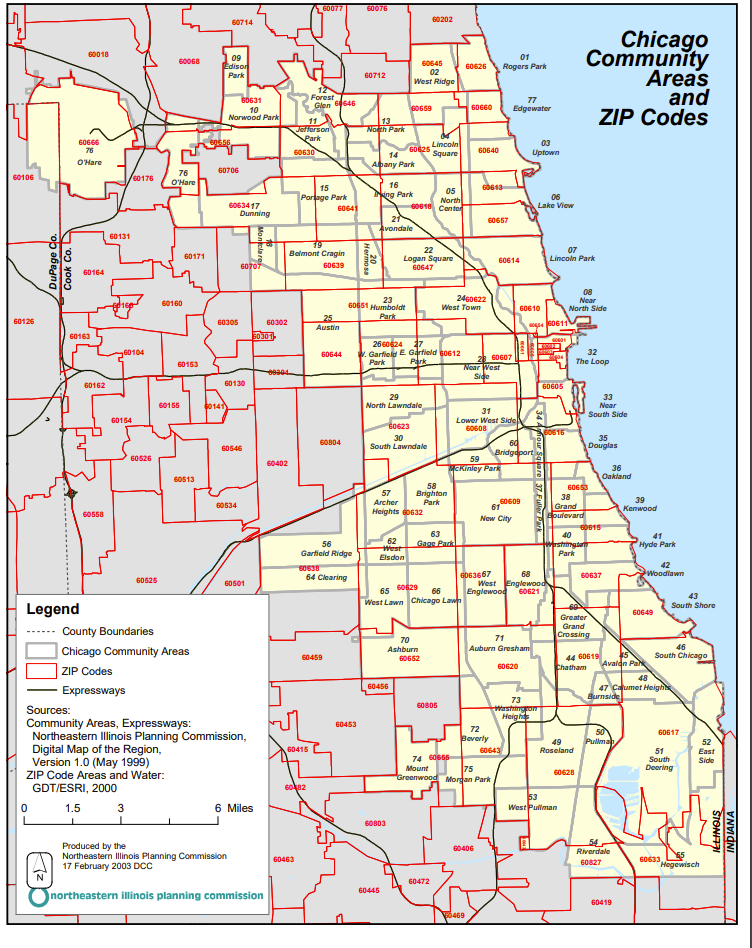

A partir de la columna community, vamos a dividir los datos en tres zonas para un mejor análisis: South, Central y North.

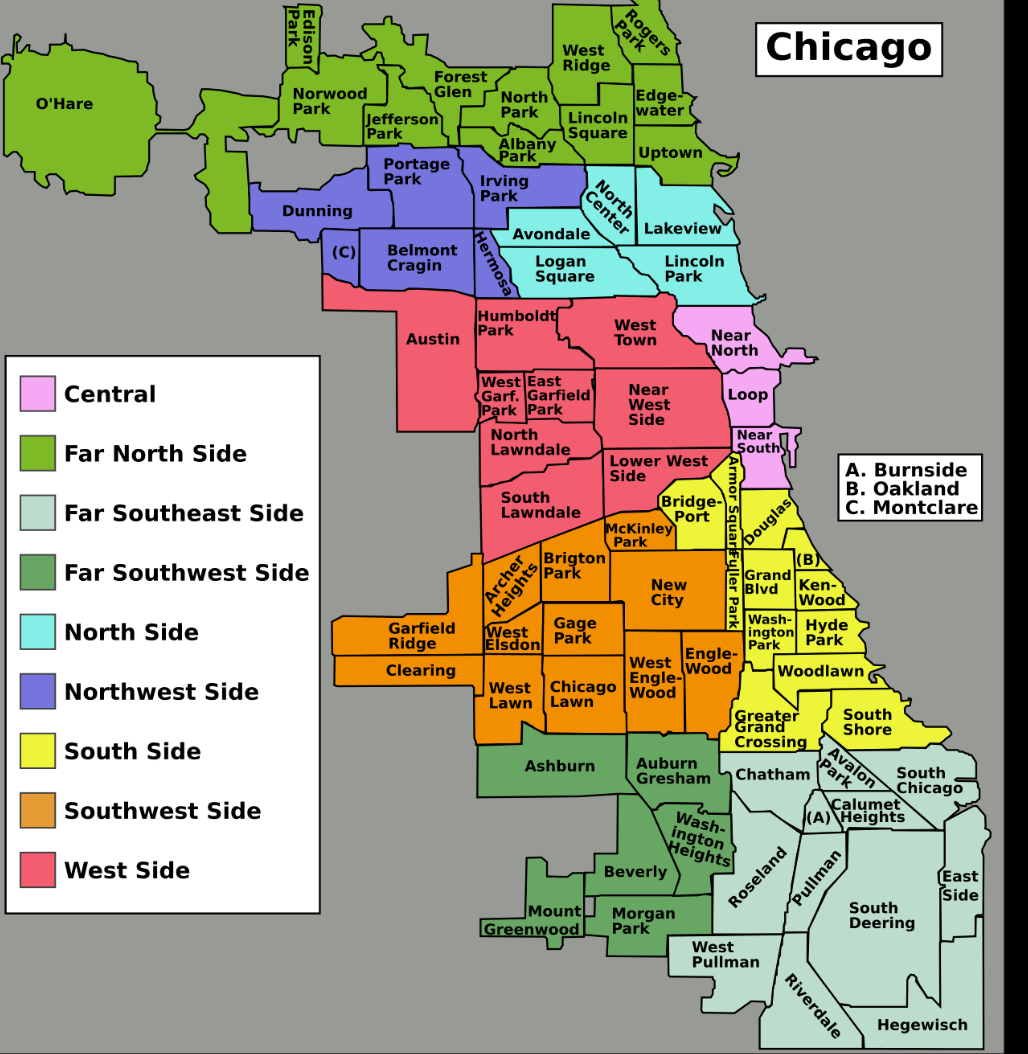

In [19]:
central_areas = [8, 32, 33]
north_areas = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
south_areas = [
    25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 
    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 
    73, 74, 75
]

# Función para asignar la zona basada en el número de área
def asignar_zona(area_num):
    if area_num in central_areas:
        return 'Central'
    elif area_num in north_areas:
        return 'North'
    elif area_num in south_areas:
        return 'South'
    else:
        return 'Outside'

In [20]:
df['zona'] = df['Community Area'].apply(asignar_zona)


Después de asignar cada registro a una zona, ya no es necesario mantener la columna community area. Por lo tanto, no la tendremos en cuenta, ya que contiene 29 valores y hemos unificado esa información en las nuevas zonas.

In [21]:
df= df.drop(columns=['Community Area'])

In [22]:
dl= df

Ya con la base de datos limpia, sin valores nulos y con las columnas seleccionadas, decidimos comenzar con el análisis descriptivo.

## ANALISIS EXPLORATORIO TABLAS

Las tablas que contienen información importante serán subidas a la nube. Esto nos ayudará a realizar un mejor análisis, ya que podremos explorar los datos disponibles de manera más eficiente. Además, los datos se agruparán y se subirán a la nube de Amazon.

In [104]:
from sqlalchemy import create_engine
import psycopg2 as ps
# Parámetros de conexión
host = "database-bigdata.ch8om1ihllt5.us-east-1.rds.amazonaws.com"
port = '5432'
user = 'postgres'
password = 'juanes25'
database = 'postgres'

# Crear el motor de SQLAlchemy
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# Probar la conexión
try:
    connection = engine.connect()
    print("Conexión exitosa a la base de datos")
    connection.close()
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")

Conexión exitosa a la base de datos


In [26]:
# Contar la frecuencia de cada tipo de crimen
crime_frequency = df['Primary Type'].value_counts()

# Convertir a DataFrame para mejor visualización
crime_frequency_df = crime_frequency.reset_index()
crime_frequency_df.columns = ['Primary_Type', 'Frequency']

crime_frequency_df


,Primary_Type,Frequency
0,THEFT,1397658
1,BATTERY,1200322
2,CRIMINAL DAMAGE,748331
3,NARCOTICS,666994
4,ASSAULT,415361
5,OTHER OFFENSE,407501
6,BURGLARY,373121
7,MOTOR VEHICLE THEFT,298680
8,DECEPTIVE PRACTICE,273212
9,ROBBERY,247305


In [107]:
# from sqlalchemy.ext.declarative import declarative_base
# from sqlalchemy import Column, String, Integer, create_engine
# from sqlalchemy.orm import sessionmaker
# import pandas as pd

# # Definir la base para el modelo ORM
# Base = declarative_base()

# # Definir el modelo para la tabla 'crime_frequency'
# class CrimeFrequency(Base):
#     __tablename__ = 'crime_frequency'
    
#     Primary_Type = Column(String(255), primary_key=True)
#     Frequency = Column(Integer)

# # Conexión a la base de datos
# # Reemplaza los valores de {user}, {password}, {host}, {port}, {database} con tus credenciales
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# # Crear la tabla en la base de datos si no existe
# Base.metadata.create_all(engine)

# # Crear una sesión
# Session = sessionmaker(bind=engine)
# session = Session()

# # Convertir la columna 'Frequency' a tipo entero si es necesario
# crime_frequency_df['Frequency'] = crime_frequency_df['Frequency'].astype(int)

# # Actualizar o insertar los datos del DataFrame en la tabla
# for index, row in crime_frequency_df.iterrows():
#     existing_record = session.query(CrimeFrequency).filter_by(Primary_Type=row['Primary_Type']).first()
#     if existing_record:
#         existing_record.Frequency = row['Frequency']
#     else:
#         nueva_frecuencia = CrimeFrequency(
#             Primary_Type=row['Primary_Type'],
#             Frequency=row['Frequency']
#         )
#         session.add(nueva_frecuencia)

# # Confirmar (commit) la transacción
# session.commit()

# # Cerrar la sesión
# session.close()

# print("Datos de frecuencia de crímenes actualizados en AWS RDS exitosamente.")


C:\Users\juane\AppData\Local\Temp\ipykernel_26080\1201732971.py:7: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Datos de frecuencia de crímenes actualizados en AWS RDS exitosamente.


In [102]:
tabla_arresto_domestico = pd.crosstab(df['Arrest'], df['Domestic'])
tabla_arresto_domestico

Domestic,False,True
Arrest,,
False,3910981,890264
True,1553858,226730


In [110]:
# from sqlalchemy.orm import declarative_base, sessionmaker
# from sqlalchemy import Column, Integer, Boolean, create_engine
# import pandas as pd

# # Definir la base para el modelo ORM
# Base = declarative_base()

# # Definir el modelo para la tabla 'arresto_domestico'
# class ArrestoDomestico(Base):
#     __tablename__ = 'arresto_domestico'
    
#     Arrest = Column(Boolean, primary_key=True)
#     Domestic = Column(Boolean, primary_key=True)
#     Count = Column(Integer)

# # Conexión a la base de datos
# # Reemplaza los valores de {user}, {password}, {host}, {port}, {database} con tus credenciales
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# # Crear la tabla en la base de datos si no existe
# Base.metadata.create_all(engine)

# # Crear una sesión
# Session = sessionmaker(bind=engine)
# session = Session()

# # Convertir tabla_arresto_domestico a DataFrame
# tabla_arresto_domestico_df = tabla_arresto_domestico.reset_index()
# tabla_arresto_domestico_df = tabla_arresto_domestico_df.melt(id_vars=['Arrest'], var_name='Domestic', value_name='Count')

# # Convertir a tipo entero
# tabla_arresto_domestico_df['Count'] = tabla_arresto_domestico_df['Count'].astype(int)

# # Insertar los datos en la base de datos
# for index, row in tabla_arresto_domestico_df.iterrows():
#     nueva_frecuencia = ArrestoDomestico(
#         Arrest=row['Arrest'],
#         Domestic=row['Domestic'],
#         Count=row['Count']
#     )
#     session.add(nueva_frecuencia)

# # Confirmar (commit) la transacción
# session.commit()

# # Cerrar la sesión
# session.close()

# print("Tabla de arresto y doméstico subida a AWS RDS exitosamente.")


Tabla de arresto y doméstico subida a AWS RDS exitosamente.


In [111]:
# Contar los casos por cada tipo de descripción de ubicación
conteos_ubicacion = df['Location Description'].value_counts().reset_index()
conteos_ubicacion.columns = ['Location Description', 'Count']

conteos_ubicacion

,Location Description,Count
0,STREET,1681706
1,RESIDENCE,1101717
2,APARTMENT,726214
3,SIDEWALK,660865
4,OTHER,243384
...,...,...
209,JUNK YARD/GARBAGE DUMP,1
210,FUNERAL PARLOR,1
211,CTA SUBWAY STATION,1
212,PUBLIC GRAMMAR SCHOOL,1


In [112]:
# from sqlalchemy.orm import declarative_base, sessionmaker
# from sqlalchemy import Column, String, Integer, create_engine
# import pandas as pd

# # Definir la base para el modelo ORM
# Base = declarative_base()

# # Definir el modelo para la tabla 'location_description_count'
# class LocationDescriptionCount(Base):
#     __tablename__ = 'location_description_count'
    
#     Location_Description = Column(String(255), primary_key=True)
#     Count = Column(Integer)

# # Conexión a la base de datos
# # Reemplaza los valores de {user}, {password}, {host}, {port}, {database} con tus credenciales
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# # Crear la tabla en la base de datos si no existe
# Base.metadata.create_all(engine)

# # Crear una sesión
# Session = sessionmaker(bind=engine)
# session = Session()

# # Convertir tabla conteos_ubicacion a una lista de objetos
# for index, row in conteos_ubicacion.iterrows():
#     nueva_ubicacion = LocationDescriptionCount(
#         Location_Description=row['Location Description'],
#         Count=row['Count']
#     )
#     session.add(nueva_ubicacion)

# # Confirmar (commit) la transacción
# session.commit()

# # Cerrar la sesión
# session.close()

# print("Tabla de conteo por descripción de ubicación subida a AWS RDS exitosamente.")


Tabla de conteo por descripción de ubicación subida a AWS RDS exitosamente.


## ANALISIS EXPLORATORIO Graficos


In [22]:
df_graficos

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,fecha,hora
24,11662417,JC232642,2019-04-21 12:30:00,009XX E 80TH ST,031A,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,...,03,1184044.0,1852159.0,2019.0,09/14/2023 03:41:59 PM,41.749500,-87.601157,"(41.749500329, -87.6011574)",2019-04-21,12:30:00
25,12218064,JD426642,2020-10-30 16:30:00,011XX E 82ND ST,0266,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,...,02,1185144.0,1850850.0,2020.0,09/14/2023 03:41:59 PM,41.745883,-87.597168,"(41.745882542, -87.597167639)",2020-10-30,16:30:00
38,12990873,JG161829,2019-08-17 13:14:00,008XX N KARLOV AVE,1751,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,...,17,1148899.0,1905351.0,2019.0,09/14/2023 03:41:59 PM,41.896215,-87.728572,"(41.89621515, -87.728572048)",2019-08-17,13:14:00
46,13158716,JG362691,2018-11-09 00:00:00,017XX N NASHVILLE AVE,0265,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,RESIDENCE,False,False,...,02,1132147.0,1910836.0,2018.0,09/14/2023 03:41:59 PM,41.911574,-87.789972,"(41.911574252, -87.789972279)",2018-11-09,00:00:00
85,7823660,HS634379,2010-11-19 09:00:00,076XX S ABERDEEN ST,0320,ROBBERY,STRONG ARM - NO WEAPON,RESIDENCE,True,False,...,03,1170306.0,1854179.0,2010.0,09/14/2023 03:41:59 PM,41.755353,-87.651440,"(41.755353249, -87.651440192)",2010-11-19,09:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,JD376740,2020-09-22 09:51:00,041XX N ROCKWELL ST,1310,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,False,False,...,14,1158338.0,1927409.0,2020.0,09/29/2020 03:42:13 PM,41.956556,-87.693300,"(41.956556089, -87.693299597)",2020-09-22,09:51:00
7391182,12087655,JD275426,2020-06-25 03:08:00,076XX S PHILLIPS AVE,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,08A,1193856.0,1854827.0,2020.0,07/02/2020 03:42:11 PM,41.756587,-87.565116,"(41.756586786, -87.565115559)",2020-06-25,03:08:00
7391183,12191680,JD397435,2020-10-10 21:00:00,070XX S MICHIGAN AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,14,1178382.0,1858313.0,2020.0,10/17/2020 03:40:42 PM,41.766518,-87.621719,"(41.766517938, -87.62171857)",2020-10-10,21:00:00
7391184,12107339,JD298144,2020-07-14 04:30:00,046XX W WAVELAND AVE,0810,THEFT,OVER $500,STREET,False,False,...,06,1144738.0,1924189.0,2020.0,07/21/2020 03:43:27 PM,41.947988,-87.743379,"(41.947987973, -87.743378752)",2020-07-14,04:30:00


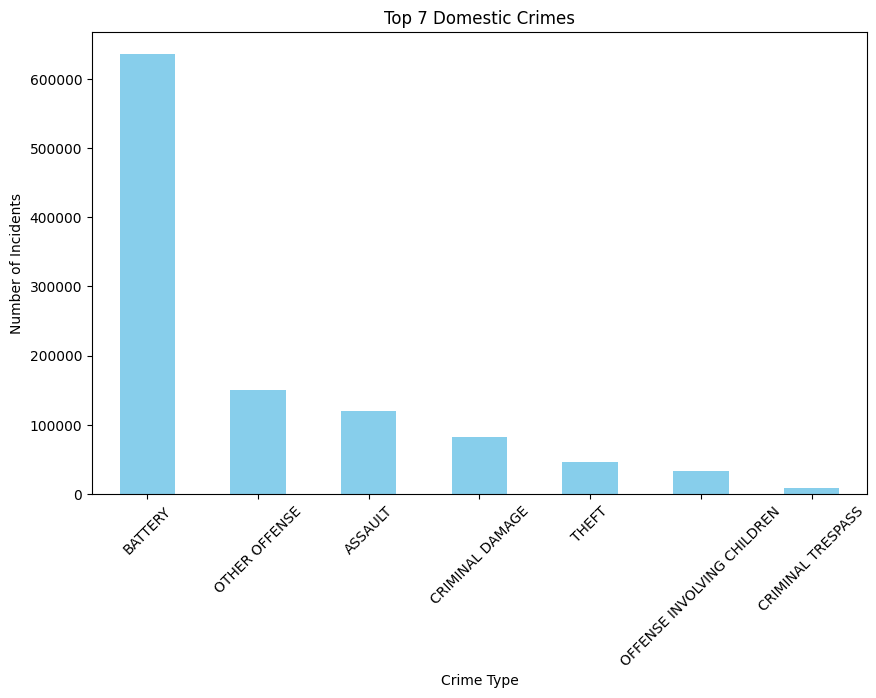

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for domestic crimes
domestic_crimes = df_graficos[df_graficos['Domestic'] == True]

# Get top 7 primary types of domestic crimes
top7_domestic_crimes = domestic_crimes['Primary Type'].value_counts().head(7)

# Plotting
plt.figure(figsize=(10, 6))
top7_domestic_crimes.plot(kind='bar', color='skyblue')
plt.title('Top 7 Domestic Crimes')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

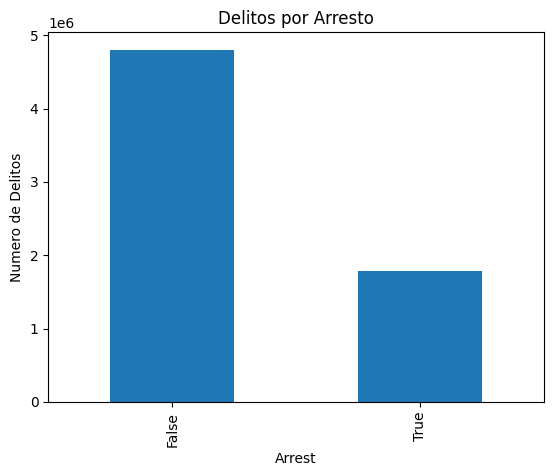

In [130]:
import matplotlib.pyplot as plt

df['Arrest'].value_counts().plot(kind='bar')
plt.xlabel('It was arrested?')
plt.ylabel('Numero de Delitos')
plt.title('Delitos por Arresto')
plt.show()  

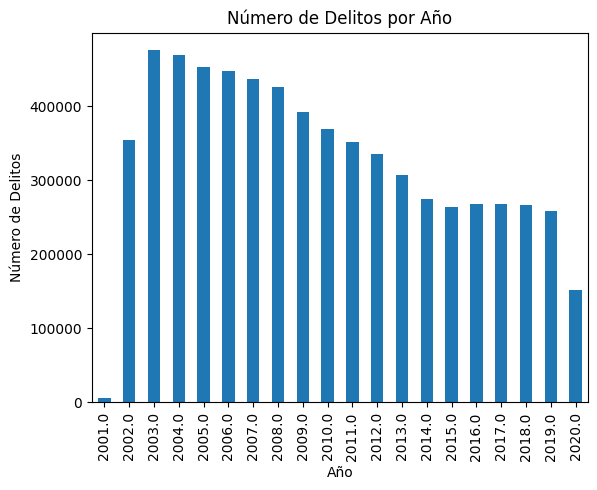

In [29]:
import matplotlib.pyplot as plt

df['Year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Año')
plt.ylabel('Número de Delitos')
plt.title('Número de Delitos por Año')
plt.show()


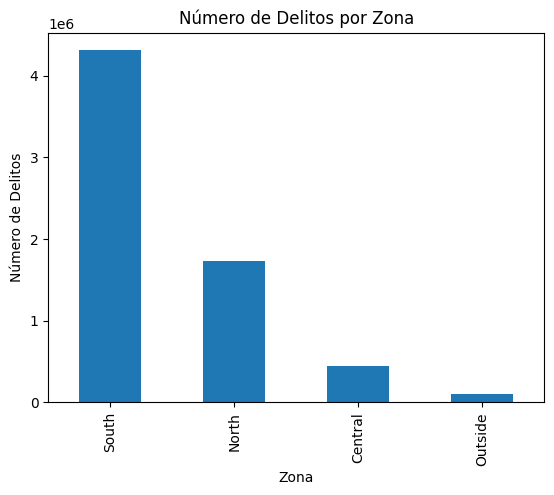

In [30]:
df['zona'].value_counts().plot(kind='bar')
plt.xlabel('Zona')
plt.ylabel('Número de Delitos')
plt.title('Número de Delitos por Zona')
plt.show()


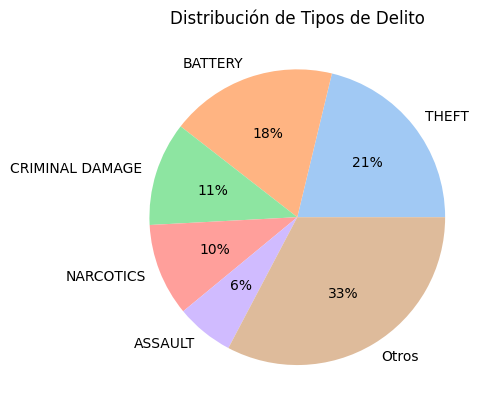

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que tu DataFrame esté correctamente definido
# df = pd.read_csv('tu_archivo.csv')  # Ejemplo de cómo cargar tu DataFrame

# Contar la frecuencia de cada tipo de delito
crime_counts = df['Primary Type'].value_counts()

# Mantener los primeros 5 tipos de delito y agrupar el resto como 'Otros'
top_5_crimes = crime_counts.nlargest(5)
other_crimes = pd.Series({'Otros': crime_counts.iloc[5:].sum()})
crime_counts_top5 = pd.concat([top_5_crimes, other_crimes])

# Definir la paleta de colores de Seaborn
colors = sns.color_palette('pastel')[0:len(crime_counts_top5)]

# Crear el gráfico de torta
plt.pie(crime_counts_top5, labels=crime_counts_top5.index, colors=colors, autopct='%.0f%%')

# Añadir un título
plt.title('Distribución de Tipos de Delito')

# Mostrar el gráfico
plt.show()



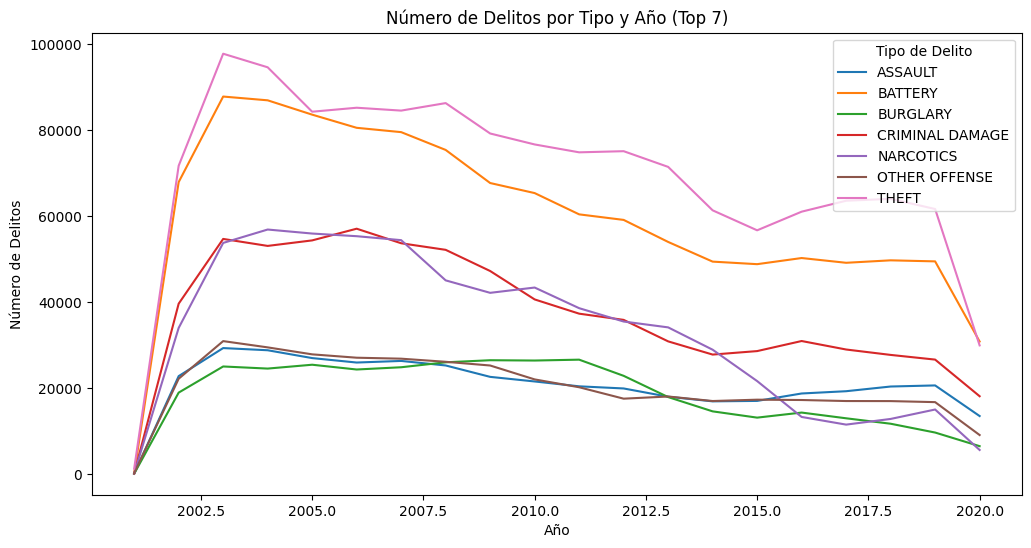

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar por 'Primary Type' para encontrar los 7 tipos de delitos más comunes
top_crimes = df.groupby('Primary Type').size().nlargest(7).index

# Filtrar el DataFrame para incluir solo los 7 tipos de delitos más comunes
df_grouped = df[df['Primary Type'].isin(top_crimes)].groupby(['Year', 'Primary Type']).size().reset_index(name='Count')

# Crear la gráfica de línea
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='Year', y='Count', hue='Primary Type')
plt.xlabel('Año')
plt.ylabel('Número de Delitos')
plt.title('Número de Delitos por Tipo y Año los primeros 7')
plt.legend(title='Tipo de Delito')
plt.show()



In [31]:
df_graficos.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6519645 entries, 24 to 7391185
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                object        
 9   Domestic              object        
 10  Beat                  float64       
 11  District              float64       
 12  Ward                  float64       
 13  Community Area        float64       
 14  FBI Code              object        
 15  X Coordinate          float64       
 16  Y Coordinate          float64       
 17  Year                  float64       
 18  Updated On            object        
 19  Lati

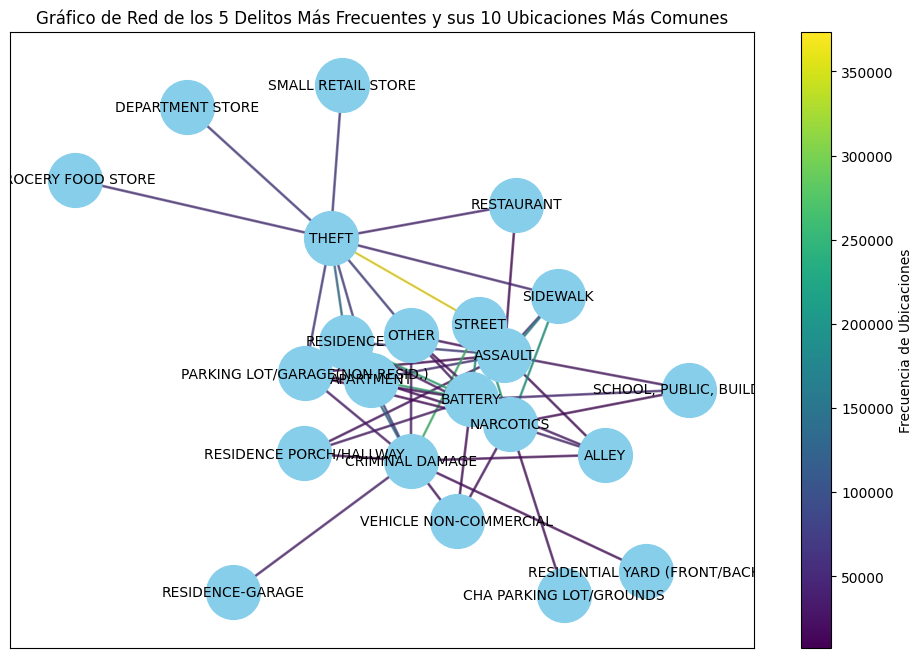

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Filtrar los 5 delitos más frecuentes
top_5_delitos = df_graficos['Primary Type'].value_counts().head(5).index
df_top_delitos = df_graficos[df_graficos['Primary Type'].isin(top_5_delitos)]

# Obtener las 10 ubicaciones más comunes para cada uno de los 5 delitos más frecuentes
top_ubicaciones = df_top_delitos.groupby('Primary Type')['Location Description'].value_counts().groupby(level=0).head(10).reset_index(name='count')

# Crear el gráfico de red
G = nx.from_pandas_edgelist(top_ubicaciones, 'Primary Type', 'Location Description', ['count'])

# Crear un mapa de colores
norm = mcolors.Normalize(vmin=top_ubicaciones['count'].min(), vmax=top_ubicaciones['count'].max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
edges = nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)
nodes = nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500, ax=ax)
labels = nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

# Dibujar los bordes con colores según la frecuencia
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])], width=2, alpha=0.6, edge_color=[cmap(norm(edge[2]['count']))], ax=ax)

plt.title('Gráfico de Red de los 5 Delitos Más Frecuentes y sus 10 Ubicaciones Más Comunes')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Frecuencia de Ubicaciones')

plt.show()






In [24]:
df_graficos

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,fecha,hora,Month
24,11662417,JC232642,2019-04-21 12:30:00,009XX E 80TH ST,031A,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,...,1184044.0,1852159.0,2019.0,09/14/2023 03:41:59 PM,41.749500,-87.601157,"(41.749500329, -87.6011574)",2019-04-21,12:30:00,2019-04
25,12218064,JD426642,2020-10-30 16:30:00,011XX E 82ND ST,0266,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,...,1185144.0,1850850.0,2020.0,09/14/2023 03:41:59 PM,41.745883,-87.597168,"(41.745882542, -87.597167639)",2020-10-30,16:30:00,2020-10
38,12990873,JG161829,2019-08-17 13:14:00,008XX N KARLOV AVE,1751,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,True,True,...,1148899.0,1905351.0,2019.0,09/14/2023 03:41:59 PM,41.896215,-87.728572,"(41.89621515, -87.728572048)",2019-08-17,13:14:00,2019-08
46,13158716,JG362691,2018-11-09 00:00:00,017XX N NASHVILLE AVE,0265,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - OTHER,RESIDENCE,False,False,...,1132147.0,1910836.0,2018.0,09/14/2023 03:41:59 PM,41.911574,-87.789972,"(41.911574252, -87.789972279)",2018-11-09,00:00:00,2018-11
85,7823660,HS634379,2010-11-19 09:00:00,076XX S ABERDEEN ST,0320,ROBBERY,STRONG ARM - NO WEAPON,RESIDENCE,True,False,...,1170306.0,1854179.0,2010.0,09/14/2023 03:41:59 PM,41.755353,-87.651440,"(41.755353249, -87.651440192)",2010-11-19,09:00:00,2010-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,JD376740,2020-09-22 09:51:00,041XX N ROCKWELL ST,1310,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,False,False,...,1158338.0,1927409.0,2020.0,09/29/2020 03:42:13 PM,41.956556,-87.693300,"(41.956556089, -87.693299597)",2020-09-22,09:51:00,2020-09
7391182,12087655,JD275426,2020-06-25 03:08:00,076XX S PHILLIPS AVE,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,1193856.0,1854827.0,2020.0,07/02/2020 03:42:11 PM,41.756587,-87.565116,"(41.756586786, -87.565115559)",2020-06-25,03:08:00,2020-06
7391183,12191680,JD397435,2020-10-10 21:00:00,070XX S MICHIGAN AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,1178382.0,1858313.0,2020.0,10/17/2020 03:40:42 PM,41.766518,-87.621719,"(41.766517938, -87.62171857)",2020-10-10,21:00:00,2020-10
7391184,12107339,JD298144,2020-07-14 04:30:00,046XX W WAVELAND AVE,0810,THEFT,OVER $500,STREET,False,False,...,1144738.0,1924189.0,2020.0,07/21/2020 03:43:27 PM,41.947988,-87.743379,"(41.947987973, -87.743378752)",2020-07-14,04:30:00,2020-07


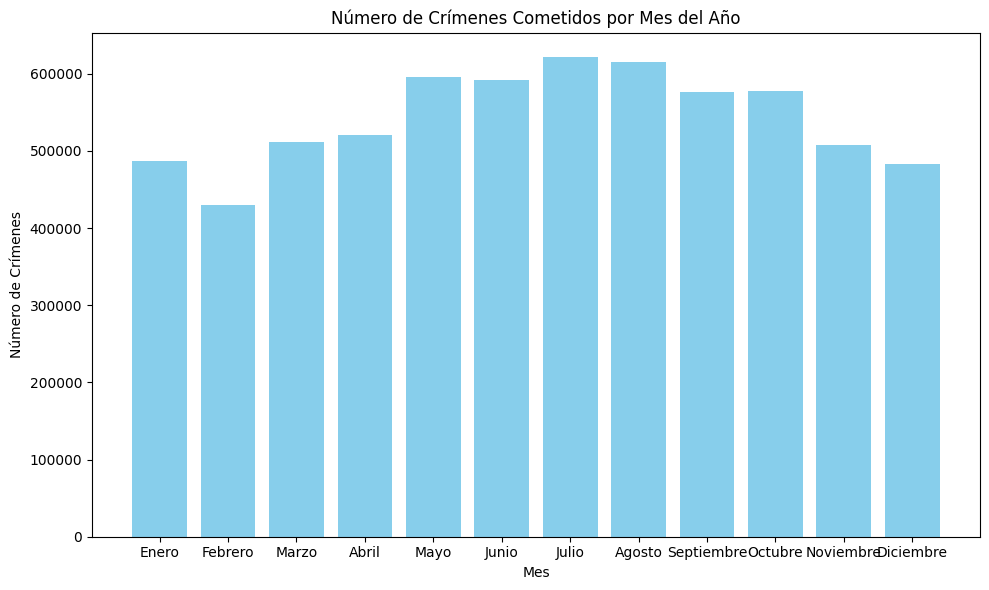

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'Date' esté en formato datetime
df_graficos['Date'] = pd.to_datetime(df_graficos['Date'], errors='coerce')

# Crear una nueva columna para el mes del año
df_graficos['Month'] = df_graficos['Date'].dt.month

# Contar el número de crímenes por mes del año
crimes_per_month = df_graficos.groupby('Month').size().reset_index(name='Crime Count')

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(crimes_per_month['Month'], crimes_per_month['Crime Count'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Número de Crímenes')
plt.title('Número de Crímenes Cometidos por Mes del Año')
plt.xticks(ticks=range(1, 13), labels=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])
plt.tight_layout()
plt.show()



¡Perfecto! Vamos a mejorar el mapa utilizando algunos plugins adicionales de folium para hacerlo más interesante y visualmente atractivo. Vamos a agregar un mini mapa y un control de capas para cambiar entre diferentes estilos de mapa.

In [37]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Filtrar los datos para asegurarnos de que tenemos latitud y longitud válidas
df_graficos = df_graficos.dropna(subset=['Latitude', 'Longitude'])

# Crear un mapa centrado en Chicago
chicago_map = folium.Map(location=[41.8781, -87.6298], zoom_start=12)

# Crear una lista de puntos de calor
heat_data = [[row['Latitude'], row['Longitude']] for index, row in df_graficos.iterrows()]

# Agregar los puntos de calor al mapa
HeatMap(heat_data).add_to(chicago_map)

# Guardar el mapa en un archivo HTML
chicago_map.save('chicago_crime_heatmap.html')



## NUBE AWS


Procederemos a subir las columnas que se utilizarán para tener un registro del estudio en la nube, ya que la base de datos se encuentra limpia.

In [34]:
from sqlalchemy import create_engine
import psycopg2 as ps
# Parámetros de conexión
host = "database-bigdata.ch8om1ihllt5.us-east-1.rds.amazonaws.com"
port = '5432'
user = 'postgres'
password = 'juanes25'
database = 'postgres'

# Crear el motor de SQLAlchemy
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# Probar la conexión
try:
    connection = engine.connect()
    print("Conexión exitosa a la base de datos")
    connection.close()
except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")


Conexión exitosa a la base de datos


In [35]:
# #from sqlalchemy.ext.declarative import declarative_base
# from sqlalchemy import Column, String, Float, Integer, Boolean, Date, Time, create_engine
# from sqlalchemy.orm import sessionmaker
# import pandas as pd

# # Definir la base para el modelo ORM
# Base = declarative_base()

# # Definir el modelo para la tabla 'crime_data'
# class CrimeData(Base):
#     __tablename__ = 'crime_data'
    
#     ID = Column(Integer, primary_key=True)
#     Primary_Type = Column(String(255))
#     Description = Column(String(255))
#     Location_Description = Column(String(255))
#     Arrest = Column(Boolean)
#     Domestic = Column(Boolean)
#     Year = Column(Float)
#     fecha = Column(Date)
#     hora = Column(Time)
#     zona = Column(String(50))

# # Conexión a la base de datos 
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# # Crear la tabla en la base de datos si no existe
# Base.metadata.create_all(engine)

# # Crear una sesión
# Session = sessionmaker(bind=engine)
# session = Session()

# # Convertir las columnas 'fecha' y 'hora' al formato adecuado si es necesario
# df['fecha'] = pd.to_datetime(df['fecha']).dt.date
# df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S').dt.time

# # Insertar los primeros 10 datos del DataFrame en la tabla
# for index, row in df.head(10).iterrows():
#     nueva_orden = CrimeData(
#         ID=row['ID'],
#         Primary_Type=row['Primary Type'],
#         Description=row['Description'],
#         Location_Description=row['Location Description'],
#         Arrest=row['Arrest'],
#         Domestic=row['Domestic'],
#         Year=row['Year'],
#         fecha=row['fecha'],
#         hora=row['hora'],
#         zona=row['zona']
#     )
#     session.add(nueva_orden)

# # Confirmar (commit) la transacción
# session.commit()

# Cerrar la sesión
#session.close()

print("Datos subidos a AWS RDS exitosamente.")

Datos subidos a AWS RDS exitosamente.


## Aprendisaje de maquina

In [36]:
dl = pd.get_dummies(dl, columns=['zona'])

In [37]:
dl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6581833 entries, 0 to 7391185
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                object 
 5   Domestic              object 
 6   Year                  float64
 7   fecha                 object 
 8   hora                  object 
 9   zona_Central          bool   
 10  zona_North            bool   
 11  zona_Outside          bool   
 12  zona_South            bool   
dtypes: bool(4), float64(1), int64(1), object(7)
memory usage: 527.3+ MB


In [38]:
# Convertir la columna 'hora' a formato de tiempo
dl['hora'] = pd.to_datetime(dl['hora'], format='%H:%M:%S').dt.time

# Definir los límites del horario laboral
hora_inicio = pd.to_datetime('08:00:00').time()
hora_fin = pd.to_datetime('17:00:00').time()

# Verificar si la hora está dentro del horario laboral
dl['es_horario_laboral'] = dl['hora'].apply(lambda x: hora_inicio <= x <= hora_fin)
dl

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Year,fecha,hora,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral
0,5741943,ASSAULT,SIMPLE,OTHER,False,False,2007.0,2007-08-25,09:22:18,False,True,False,False,True
24,11662417,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,2019.0,2019-04-21,12:30:00,False,False,False,True,True
25,12218064,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,2020.0,2020-10-30,16:30:00,False,False,False,True,True
27,12416972,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,False,True,2020.0,2020-10-01,00:01:00,False,False,False,True,False
28,12416974,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,False,True,2011.0,2011-08-10,00:01:00,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,False,False,2020.0,2020-09-22,09:51:00,False,True,False,False,True
7391182,12087655,ASSAULT,SIMPLE,RESIDENCE,False,False,2020.0,2020-06-25,03:08:00,False,False,False,True,False
7391183,12191680,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2020.0,2020-10-10,21:00:00,False,False,False,True,False
7391184,12107339,THEFT,OVER $500,STREET,False,False,2020.0,2020-07-14,04:30:00,False,True,False,False,False


In [39]:
dl.drop(columns=['hora'], inplace=True)
dl

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Year,fecha,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral
0,5741943,ASSAULT,SIMPLE,OTHER,False,False,2007.0,2007-08-25,False,True,False,False,True
24,11662417,ROBBERY,ARMED - HANDGUN,RESIDENCE,False,False,2019.0,2019-04-21,False,False,False,True,True
25,12218064,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,True,True,2020.0,2020-10-30,False,False,False,True,True
27,12416972,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,False,True,2020.0,2020-10-01,False,False,False,True,False
28,12416974,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,False,True,2011.0,2011-08-10,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,False,False,2020.0,2020-09-22,False,True,False,False,True
7391182,12087655,ASSAULT,SIMPLE,RESIDENCE,False,False,2020.0,2020-06-25,False,False,False,True,False
7391183,12191680,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2020.0,2020-10-10,False,False,False,True,False
7391184,12107339,THEFT,OVER $500,STREET,False,False,2020.0,2020-07-14,False,True,False,False,False


In [40]:
dl.drop(columns=['Year'], inplace=True)

Para considerar la hora dentro de nuestro estudio, vamos a clasificar si la denuncia se realizó durante horas laborales o no. Esto nos permitirá analizar los resultados y tener en cuenta esta variable en nuestro modelo de aprendizaje automático.

Ahora para los meses vamos a conocer si la estacion puede afectar a nuestro objetivo principal

In [41]:

# Convertir a datetime
dl['fecha'] = pd.to_datetime(dl['fecha'])

# Función para asignar la estación
def asignar_estacion(fecha):
    mes = fecha.month
    if mes in [3, 4, 5]:
        return 'Primavera'
    elif mes in [6, 7, 8]:
        return 'Verano'
    elif mes in [9, 10, 11]:
        return 'Otoño'
    else:
        return 'Invierno'

# Aplicar la función para asignar estación
dl['estacion'] = dl['fecha'].apply(asignar_estacion)



In [42]:
dl = pd.get_dummies(dl, columns=['estacion'])

In [43]:
dl.drop(columns=['fecha'], inplace=True)

In [44]:
dl = dl.replace({True: 1, False: 0})
dl

C:\Users\juane\AppData\Local\Temp\ipykernel_26080\2477919036.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dl = dl.replace({True: 1, False: 0})


,ID,Primary Type,Description,Location Description,Arrest,Domestic,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
0,5741943,ASSAULT,SIMPLE,OTHER,0,0,0,1,0,0,1,0,0,0,1
24,11662417,ROBBERY,ARMED - HANDGUN,RESIDENCE,0,0,0,0,0,1,1,0,0,1,0
25,12218064,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,1,1,0,0,0,1,1,0,1,0,0
27,12416972,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,0,1,0,0,0,1,0,0,1,0,0
28,12416974,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,0,0,0,1,0,0,1,0,1,0,0
7391182,12087655,ASSAULT,SIMPLE,RESIDENCE,0,0,0,0,0,1,0,0,0,0,1
7391183,12191680,CRIMINAL DAMAGE,TO VEHICLE,STREET,0,0,0,0,0,1,0,0,1,0,0
7391184,12107339,THEFT,OVER $500,STREET,0,0,0,1,0,0,0,0,0,0,1


In [45]:
valores_unicos = dl['Primary Type'].unique()
print(valores_unicos)

['ASSAULT' 'ROBBERY' 'CRIMINAL SEXUAL ASSAULT'
 'OFFENSE INVOLVING CHILDREN' 'DECEPTIVE PRACTICE' 'THEFT' 'SEX OFFENSE'
 'BATTERY' 'BURGLARY' 'WEAPONS VIOLATION' 'HOMICIDE' 'OTHER OFFENSE'
 'NARCOTICS' 'CRIMINAL DAMAGE' 'MOTOR VEHICLE THEFT' 'CRIMINAL TRESPASS'
 'CRIM SEXUAL ASSAULT' 'STALKING' 'ARSON' 'OBSCENITY' 'KIDNAPPING'
 'INTERFERENCE WITH PUBLIC OFFICER' 'PUBLIC PEACE VIOLATION'
 'INTIMIDATION' 'HUMAN TRAFFICKING' 'PROSTITUTION' 'GAMBLING'
 'LIQUOR LAW VIOLATION' 'OTHER NARCOTIC VIOLATION' 'PUBLIC INDECENCY'
 'RITUALISM' 'NON-CRIMINAL' 'NON-CRIMINAL (SUBJECT SPECIFIED)'
 'NON - CRIMINAL' 'CONCEALED CARRY LICENSE VIOLATION']


In [46]:

valores_unicos = dl['Description'].unique()
a = len(valores_unicos)
print(a)
print (valores_unicos)


531
['SIMPLE' 'ARMED - HANDGUN' 'PREDATORY'
 'SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER'
 'CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER' 'AGGRAVATED - OTHER'
 'AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER'
 'STRONG ARM - NO WEAPON'
 'AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER'
 'FINANCIAL IDENTITY THEFT OVER $ 300' 'FROM BUILDING' 'OVER $500'
 'EMBEZZLEMENT' 'CRIMINAL SEXUAL ABUSE' 'AGGRAVATED - HANDGUN'
 'ARMED - KNIFE / CUTTING INSTRUMENT' 'ATTEMPT ARMED - HANDGUN'
 'ATTEMPT STRONG ARM - NO WEAPON'
 'AGGRAVATED - KNIFE / CUTTING INSTRUMENT'
 'AGGRAVATED CRIMINAL SEXUAL ABUSE' 'AGGRAVATED OF A SENIOR CITIZEN'
 'NON-AGGRAVATED' 'HOME INVASION' 'DOMESTIC BATTERY SIMPLE'
 'RECKLESS FIREARM DISCHARGE' 'FRAUD OR CONFIDENCE GAME' '$500 AND UNDER'
 'FIRST DEGREE MURDER' 'ENDANGERING LIFE / HEALTH OF CHILD'
 'FORCIBLE ENTRY' 'TELEPHONE THREAT' 'POSS: HEROIN(WHITE)' 'POSS: CRACK'
 'TO VEHICLE' 'ATTEMPT ARMED - KNIFE / CUTTING INSTRUMENT'
 'HARASSMENT BY ELECTRONIC MEANS' 'AUTOMOBILE' 'O

Se eliminará la columna description ya que no se podría realizar un análisis de lenguaje natural (NLP) efectivo con solo 531 datos únicos de más de 6 millones. Por lo tanto, no se considerará en el modelo de aprendizaje automático y se ha decidido eliminarla.

In [47]:
valores_unicos = dl['Location Description'].unique()
a = len(valores_unicos)
print(a)
print(valores_unicos)

214
['OTHER' 'RESIDENCE' 'APARTMENT' 'BAR OR TAVERN'
 'PARKING LOT / GARAGE (NON RESIDENTIAL)' 'STREET'
 'COMMERCIAL / BUSINESS OFFICE' 'HOSPITAL BUILDING / GROUNDS' 'SIDEWALK'
 'RESTAURANT' 'PARK PROPERTY' 'DEPARTMENT STORE' 'RESIDENCE - GARAGE'
 'ALLEY' 'CHA PARKING LOT / GROUNDS' 'ATHLETIC CLUB' 'APPLIANCE STORE'
 'CTA TRAIN' 'SCHOOL - PUBLIC BUILDING' 'OTHER (SPECIFY)'
 'SCHOOL - PRIVATE BUILDING' 'CHA APARTMENT' 'TAVERN / LIQUOR STORE'
 'CREDIT UNION' 'RESIDENCE - PORCH / HALLWAY' 'GAS STATION'
 'CONSTRUCTION SITE' 'RESIDENCE - YARD (FRONT / BACK)'
 'GOVERNMENT BUILDING / PROPERTY' 'VEHICLE NON-COMMERCIAL'
 'CURRENCY EXCHANGE' 'NURSING / RETIREMENT HOME'
 'CHURCH / SYNAGOGUE / PLACE OF WORSHIP' 'BANK' 'VACANT LOT / LAND'
 'GROCERY FOOD STORE' 'AIRPORT/AIRCRAFT' 'HOTEL / MOTEL'
 'SMALL RETAIL STORE' 'CTA BUS' 'MEDICAL / DENTAL OFFICE'
 'ABANDONED BUILDING' 'HOUSE' 'PARKING LOT/GARAGE(NON.RESID.)' 'LIBRARY'
 'TAVERN/LIQUOR STORE' 'WAREHOUSE' 'AUTO'
 'CHURCH/SYNAGOGUE/PLACE OF WORSHI

Ahora para poder clasificar la gravedad del crimen vamos a clasificarlo de 1 a 5 donde tuvimos en cuenta un crimen

In [48]:

# Definir la escala de gravedad
crime_severity = {
    'HOMICIDE': 5,
    'CRIMINAL SEXUAL ASSAULT': 5,
    'CRIM SEXUAL ASSAULT': 5,
    'OFFENSE INVOLVING CHILDREN': 5,
    'KIDNAPPING': 5,
    'HUMAN TRAFFICKING': 5,
    'ASSAULT': 4,
    'ROBBERY': 4,
    'BATTERY': 4,
    'WEAPONS VIOLATION': 4,
    'ARSON': 4,
    'STALKING': 4,
    'BURGLARY': 3,
    'NARCOTICS': 3,
    'CRIMINAL DAMAGE': 3,
    'MOTOR VEHICLE THEFT': 3,
    'CRIMINAL TRESPASS': 3,
    'SEX OFFENSE': 3,
    'DECEPTIVE PRACTICE': 2,
    'THEFT': 2,
    'PROSTITUTION': 2,
    'GAMBLING': 2,
    'LIQUOR LAW VIOLATION': 2,
    'OTHER NARCOTIC VIOLATION': 2,
    'PUBLIC PEACE VIOLATION': 2,
    'INTIMIDATION': 2,
    'INTERFERENCE WITH PUBLIC OFFICER': 2,
    'OBSCENITY': 1,
    'PUBLIC INDECENCY': 1,
    'RITUALISM': 1,
    'NON-CRIMINAL': 1,
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 1,
    'NON - CRIMINAL': 1,
    'CONCEALED CARRY LICENSE VIOLATION': 1,
    'OTHER OFFENSE': 1
}

# Supongamos que tu DataFrame se llama df y tiene una columna 'Primary_Type' con los tipos de crímenes
dl['Severity_Level'] = dl['Primary Type'].map(crime_severity)

dl

,ID,Primary Type,Description,Location Description,Arrest,Domestic,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,Severity_Level
0,5741943,ASSAULT,SIMPLE,OTHER,0,0,0,1,0,0,1,0,0,0,1,4
24,11662417,ROBBERY,ARMED - HANDGUN,RESIDENCE,0,0,0,0,0,1,1,0,0,1,0,4
25,12218064,CRIMINAL SEXUAL ASSAULT,PREDATORY,RESIDENCE,1,1,0,0,0,1,1,0,1,0,0,5
27,12416972,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,0,1,0,0,0,1,0,0,1,0,0,5
28,12416974,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,0,1,0,0,0,1,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,12173782,CRIMINAL DAMAGE,TO PROPERTY,HOSPITAL BUILDING / GROUNDS,0,0,0,1,0,0,1,0,1,0,0,3
7391182,12087655,ASSAULT,SIMPLE,RESIDENCE,0,0,0,0,0,1,0,0,0,0,1,4
7391183,12191680,CRIMINAL DAMAGE,TO VEHICLE,STREET,0,0,0,0,0,1,0,0,1,0,0,3
7391184,12107339,THEFT,OVER $500,STREET,0,0,0,1,0,0,0,0,0,0,1,2


In [49]:
dl.drop(columns=['Primary Type'], inplace=True)

In [50]:
dl.drop(columns=['Description'], inplace=True)

In [51]:
dl.drop(columns=['ID'], inplace=True)

In [52]:
dl

,Location Description,Arrest,Domestic,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,Severity_Level
0,OTHER,0,0,0,1,0,0,1,0,0,0,1,4
24,RESIDENCE,0,0,0,0,0,1,1,0,0,1,0,4
25,RESIDENCE,1,1,0,0,0,1,1,0,1,0,0,5
27,RESIDENCE,0,1,0,0,0,1,0,0,1,0,0,5
28,RESIDENCE,0,1,0,0,0,1,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,HOSPITAL BUILDING / GROUNDS,0,0,0,1,0,0,1,0,1,0,0,3
7391182,RESIDENCE,0,0,0,0,0,1,0,0,0,0,1,4
7391183,STREET,0,0,0,0,0,1,0,0,1,0,0,3
7391184,STREET,0,0,0,1,0,0,0,0,0,0,1,2


In [53]:
valores_unicos_lista = dl['Location Description'].unique().tolist()

# Mostrar los valores únicos en formato de lista
print(valores_unicos_lista)

['OTHER', 'RESIDENCE', 'APARTMENT', 'BAR OR TAVERN', 'PARKING LOT / GARAGE (NON RESIDENTIAL)', 'STREET', 'COMMERCIAL / BUSINESS OFFICE', 'HOSPITAL BUILDING / GROUNDS', 'SIDEWALK', 'RESTAURANT', 'PARK PROPERTY', 'DEPARTMENT STORE', 'RESIDENCE - GARAGE', 'ALLEY', 'CHA PARKING LOT / GROUNDS', 'ATHLETIC CLUB', 'APPLIANCE STORE', 'CTA TRAIN', 'SCHOOL - PUBLIC BUILDING', 'OTHER (SPECIFY)', 'SCHOOL - PRIVATE BUILDING', 'CHA APARTMENT', 'TAVERN / LIQUOR STORE', 'CREDIT UNION', 'RESIDENCE - PORCH / HALLWAY', 'GAS STATION', 'CONSTRUCTION SITE', 'RESIDENCE - YARD (FRONT / BACK)', 'GOVERNMENT BUILDING / PROPERTY', 'VEHICLE NON-COMMERCIAL', 'CURRENCY EXCHANGE', 'NURSING / RETIREMENT HOME', 'CHURCH / SYNAGOGUE / PLACE OF WORSHIP', 'BANK', 'VACANT LOT / LAND', 'GROCERY FOOD STORE', 'AIRPORT/AIRCRAFT', 'HOTEL / MOTEL', 'SMALL RETAIL STORE', 'CTA BUS', 'MEDICAL / DENTAL OFFICE', 'ABANDONED BUILDING', 'HOUSE', 'PARKING LOT/GARAGE(NON.RESID.)', 'LIBRARY', 'TAVERN/LIQUOR STORE', 'WAREHOUSE', 'AUTO', 'CHUR

Se eliminará la columna description ya que no se podría realizar un análisis de lenguaje natural (NLP) efectivo con solo 531 datos únicos de más de 6 millones. Por lo tanto, no se considerará en el modelo de aprendizaje automático y se ha decidido eliminarla.

In [54]:
# Supongamos que tu DataFrame se llama df y tiene una columna 'Location_Description'
residential_keywords = ['RESIDENCE', 'APARTMENT', 'HOUSE', 'YARD', 'GARAGE', 'CHA APARTMENT', 'CHA LOBBY', 'CHA HALLWAY', 'CHA STAIRWELL', 'CHA ELEVATOR', 'CHA GROUNDS', 'CHA PLAY LOT', 'CHA BREEZEWAY', 'CHA PARKING LOT/GROUNDS']

# Función para clasificar las ubicaciones como residenciales (1) o no residenciales (0)
def classify_location(description):
    for keyword in residential_keywords:
        if keyword in description:
            return 1
    return 0

# Aplicar la función a la columna 'Location_Description'
dl['Residencial'] = dl['Location Description'].apply(classify_location)

In [55]:
dl

,Location Description,Arrest,Domestic,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,Severity_Level,Residencial
0,OTHER,0,0,0,1,0,0,1,0,0,0,1,4,0
24,RESIDENCE,0,0,0,0,0,1,1,0,0,1,0,4,1
25,RESIDENCE,1,1,0,0,0,1,1,0,1,0,0,5,1
27,RESIDENCE,0,1,0,0,0,1,0,0,1,0,0,5,1
28,RESIDENCE,0,1,0,0,0,1,0,0,0,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,HOSPITAL BUILDING / GROUNDS,0,0,0,1,0,0,1,0,1,0,0,3,0
7391182,RESIDENCE,0,0,0,0,0,1,0,0,0,0,1,4,1
7391183,STREET,0,0,0,0,0,1,0,0,1,0,0,3,0
7391184,STREET,0,0,0,1,0,0,0,0,0,0,1,2,0


Dado que hemos utilizado la columna Location_Description, procederemos a eliminarla para preparar los datos para el aprendizaje automático. Esto nos permitirá utilizar todas las características restantes para entrenar un modelo de machine learning que prediga si una persona será arrestada, basándose en los datos disponibles.

In [56]:
dl.drop(columns=['Location Description'], inplace=True)

In [57]:
dl

,Arrest,Domestic,zona_Central,zona_North,zona_Outside,zona_South,es_horario_laboral,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,Severity_Level,Residencial
0,0,0,0,1,0,0,1,0,0,0,1,4,0
24,0,0,0,0,0,1,1,0,0,1,0,4,1
25,1,1,0,0,0,1,1,0,1,0,0,5,1
27,0,1,0,0,0,1,0,0,1,0,0,5,1
28,0,1,0,0,0,1,0,0,0,0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7391181,0,0,0,1,0,0,1,0,1,0,0,3,0
7391182,0,0,0,0,0,1,0,0,0,0,1,4,1
7391183,0,0,0,0,0,1,0,0,1,0,0,3,0
7391184,0,0,0,1,0,0,0,0,0,0,1,2,0


In [58]:
X = dl.drop(columns=['Arrest'])
y = dl['Arrest']


In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Normalización
scaler = MinMaxScaler()
X=scaler.fit_transform(X)

# Estandarización
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Verificando que todas las variables estén en formato numérico.

## Decision Tree

In [114]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [115]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [116]:
y_pred = model.predict(X_test) 

In [117]:
# Obtener las probabilidades de la clase positiva
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva

In [118]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.7449130827497195
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84    960988
           1       0.56      0.28      0.37    355379

    accuracy                           0.74   1316367
   macro avg       0.66      0.60      0.61   1316367
weighted avg       0.72      0.74      0.71   1316367



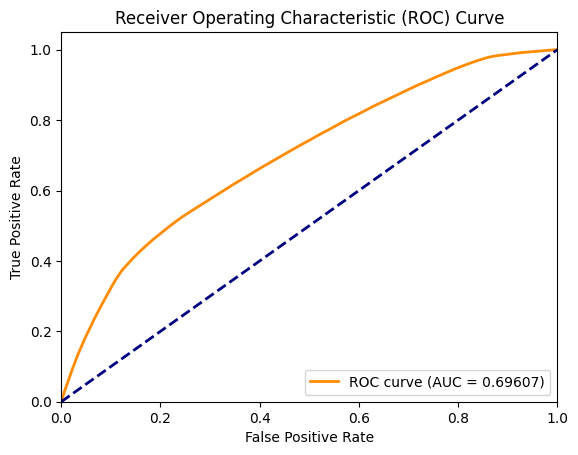

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular los valores fpr, tpr y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [91]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.730030455032677


c:\Users\juane\miniconda3\envs\computacion_paralelo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.73      1.00      0.84    960988
           1       0.00      0.00      0.00    355379

    accuracy                           0.73   1316367
   macro avg       0.37      0.50      0.42   1316367
weighted avg       0.53      0.73      0.62   1316367



c:\Users\juane\miniconda3\envs\computacion_paralelo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juane\miniconda3\envs\computacion_paralelo\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


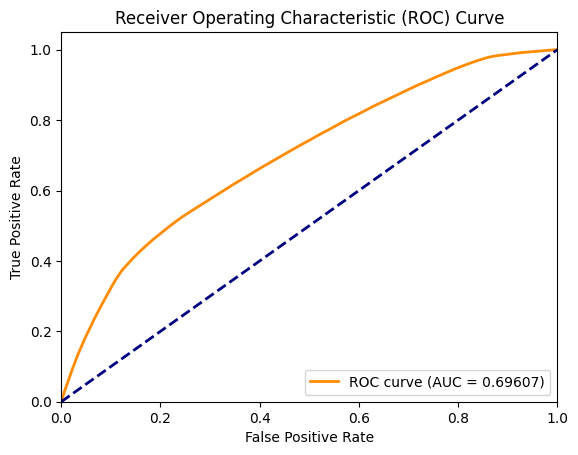

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular los valores fpr, tpr y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Naive bayes

In [94]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [95]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.7207518875815028
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.77      0.89      0.82    960988
           1       0.47      0.26      0.33    355379

    accuracy                           0.72   1316367
   macro avg       0.62      0.58      0.58   1316367
weighted avg       0.69      0.72      0.69   1316367



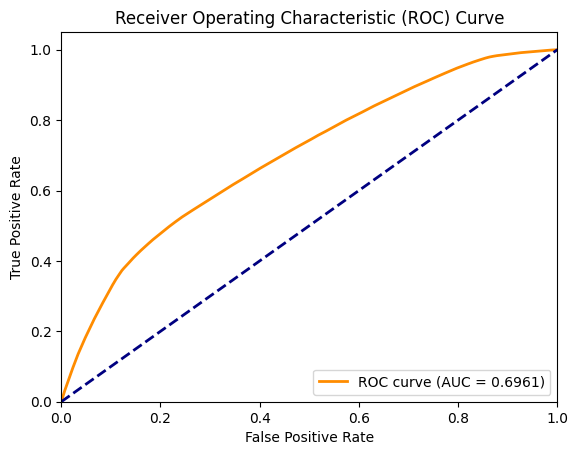

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular los valores fpr, tpr y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Gradien boost

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

# Crear el modelo
model = GradientBoostingClassifier(verbose=1)

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones con los datos de prueba
y_pred = model.predict(X_test)


      Iter       Train Loss   Remaining Time 
         1           1.1511            9.36m
         2           1.1377            9.13m
         3           1.1270            9.02m
         4           1.1182            8.80m
         5           1.1111            8.76m
         6           1.1051            8.64m
         7           1.1002            8.50m
         8           1.0955            8.44m
         9           1.0920            8.33m
        10           1.0886            8.28m
        20           1.0726            9.17m
        30           1.0670            7.65m
        40           1.0644            8.03m
        50           1.0626            6.58m
        60           1.0614            4.90m
        70           1.0608            3.47m
        80           1.0602            2.22m
        90           1.0598            1.07m
       100           1.0596            0.00s


In [124]:
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Accuracy: 0.7440098392013778
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84    960988
           1       0.55      0.26      0.36    355379

    accuracy                           0.74   1316367
   macro avg       0.66      0.59      0.60   1316367
weighted avg       0.71      0.74      0.71   1316367



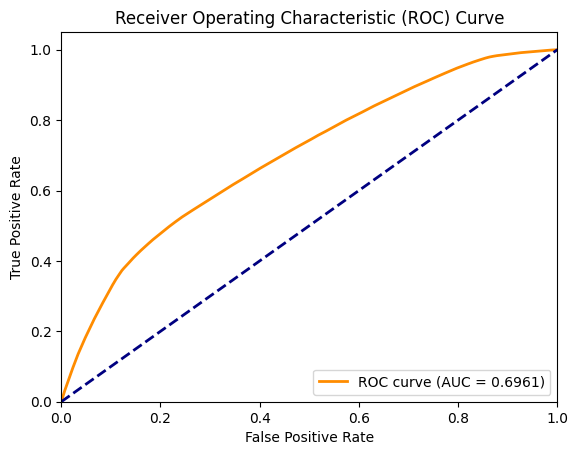

In [126]:
from sklearn.metrics import roc_curve, roc_auc_score
# Calcular los valores fpr, tpr y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_prob)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Se va escoger el modelo que sea con el decision tree pero queremos aumentar el roc por lo que vamos a utilizar los hiperparametros. Para encontrar los adecuados y tener nuestro mejor modelo.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# Supongamos que tienes un DataFrame llamado df con las características y la variable objetivo
X = dl.drop('Arrest', axis=1)
y = dl['Arrest']

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)



In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Definir el modelo
dt = DecisionTreeClassifier()

# Definir los hiperparámetros a ajustar
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='roc_auc')

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Evaluar el modelo
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC AUC Score: {roc_auc}')


ROC AUC Score: 0.6960626935559597


## Tabla de metricas del modelo a AWS

ya con el algoritmo realizado procedemos a subir las metricas de este mismo a la nube para que las personas tengan acceso a este desde cualquier lugar. Puedan explorar la efectividad del modelo

In [128]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Supongamos que y_test y y_pred ya están definidos
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Convertir el reporte de clasificación a un DataFrame
report_df = pd.DataFrame(report).transpose()

# Añadir la precisión al DataFrame
report_df.loc['accuracy'] = [accuracy] + [None] * (len(report_df.columns) - 1)

In [131]:
print(report_df.columns)


Index(['precision', 'recall', 'f1-score', 'support'], dtype='object')


In [133]:
# from sqlalchemy.ext.declarative import declarative_base
# from sqlalchemy import Column, String, Float, Integer, create_engine
# from sqlalchemy.orm import sessionmaker
# import pandas as pd
# from sklearn.metrics import accuracy_score, classification_report

# # Definir la base para el modelo ORM
# Base = declarative_base()

# # Definir el modelo para la tabla 'evaluation_metrics'
# class EvaluationMetrics(Base):
#     __tablename__ = 'evaluation_metrics'
    
#     id = Column(Integer, primary_key=True, autoincrement=True)
#     metric_name = Column(String(50))
#     value = Column(Float)
#     detail = Column(String)


# # Conexión a la base de datos 
# engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# # Crear la tabla en la base de datos si no existe
# Base.metadata.create_all(engine)

# # Crear una sesión
# Session = sessionmaker(bind=engine)
# session = Session()

# # Supongamos que y_test y y_pred ya están definidos
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred, output_dict=True)

# # Convertir el reporte de clasificación a un DataFrame
# report_df = pd.DataFrame(report).transpose()

# # Añadir la precisión al DataFrame
# report_df.loc['accuracy'] = [accuracy] + [None] * (len(report_df.columns) - 1)

# # Renombrar las columnas del DataFrame
# report_df = report_df.reset_index().rename(columns={'index': 'metric_name', 'support': 'detail'})

# # Insertar los datos en la base de datos
# session.bulk_insert_mappings(
#     EvaluationMetrics,
#     [
#         {'metric_name': row['metric_name'], 'value': row['precision'], 'detail': row['detail']}
#         for _, row in report_df.iterrows()
#     ]
# )

# # Confirmar (commit) la transacción
# session.commit()

# # Cerrar la sesión
# session.close()

# print("Métricas subidas a AWS RDS exitosamente.")


C:\Users\juane\AppData\Local\Temp\ipykernel_26080\3276659229.py:8: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Métricas subidas a AWS RDS exitosamente.


Se procede a guardar el modelo

In [134]:
import joblib

# Guardar el modelo entrenado
joblib.dump(best_model, 'best_decision_tree_model.pkl')


['best_decision_tree_model.pkl']

In [135]:
import joblib

# Cargar el modelo
loaded_model = joblib.load('best_decision_tree_model.pkl')
